In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical



In [2]:
DATA_PATH = "/Users/jubyaiduddin/Downloads/Senior_design/paper_reproduction/data/anemia.csv"
def load_and_clean(path=DATA_PATH):
    df = pd.read_csv(path, index_col=False)
    df.columns = df.columns.str.strip()
    # keep raw features + original Result
    df = df[["Gender", "Hemoglobin", "MCH", "MCHC", "MCV", "Result"]]
    # ensure Gender is numeric: 0 = male, 1 = female
    df["Gender"] = pd.to_numeric(df["Gender"], errors="raise")
    # recompute binary anemia flag per paper:
    # male (0): HGB < 13.6 → anemic; female (1): HGB < 12.0 → anemic
    df["AnemiaFlag"] = (
        ((df["Gender"] == 0) & (df["Hemoglobin"] < 13.6)) |
        ((df["Gender"] == 1) & (df["Hemoglobin"] < 12.0))
    ).astype(int)
    # derive 4-class Target per Table 3 & 4
    def to_target(r):
        if r["AnemiaFlag"] == 0:
            return 0  # no anemia
        if r["MCV"] < 80:
            return 1  # microcytic
        elif r["MCV"] <= 100:
            return 2  # normocytic
        else:
            return 3  # macrocytic
    df["Target"] = df.apply(to_target, axis=1)
    # drop helper columns
    #df = df.drop(columns=["Result", "AnemiaFlag"])
    # fill any remaining missing values
    if df.isnull().any().any():
        df = df.fillna(df.mean())
    return df

# load & inspect
df = load_and_clean()
print(f"Loaded {df.shape[0]} samples with columns: {df.columns.tolist()}")
df.head()

Loaded 1421 samples with columns: ['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV', 'Result', 'AnemiaFlag', 'Target']


,Gender,Hemoglobin,MCH,MCHC,MCV,Result,AnemiaFlag,Target
0,1,14.9,22.7,29.1,83.7,0,0,0
1,0,15.9,25.4,28.3,72.0,0,0,0
2,0,9.0,21.5,29.6,71.2,1,1,1
3,0,14.9,16.0,31.4,87.5,0,0,0
4,1,14.7,22.0,28.2,99.5,0,0,0


In [3]:
df

,Gender,Hemoglobin,MCH,MCHC,MCV,Result,AnemiaFlag,Target
0,1,14.9,22.7,29.1,83.7,0,0,0
1,0,15.9,25.4,28.3,72.0,0,0,0
2,0,9.0,21.5,29.6,71.2,1,1,1
3,0,14.9,16.0,31.4,87.5,0,0,0
4,1,14.7,22.0,28.2,99.5,0,0,0
...,...,...,...,...,...,...,...,...
1416,0,10.6,25.4,28.2,82.9,1,1,2
1417,1,12.1,28.3,30.4,86.9,1,0,0
1418,1,13.1,17.7,28.1,80.7,1,0,0
1419,0,14.3,16.2,29.5,95.2,0,0,0


In [4]:
#df.to_csv('processed_anemia_data.csv', index= False)

In [5]:
print("\nFeature summary (mean, min, max):")
print(df[["Hemoglobin","MCV","MCH","MCHC"]]
      .describe().loc[["mean","min","max"]])
print("\n4-class distribution (0=no,1=micro,2=normo,3=macro):")
print(df["Target"].value_counts().sort_index())


Feature summary (mean, min, max):
      Hemoglobin         MCV       MCH       MCHC
mean   13.412738   85.523786  22.90563  30.251232
min     6.600000   69.400000  16.00000  27.800000
max    16.900000  101.600000  30.00000  32.500000

4-class distribution (0=no,1=micro,2=normo,3=macro):
Target
0    857
1    175
2    341
3     48
Name: count, dtype: int64


In [6]:
X = df[["Gender","Hemoglobin","MCH","MCHC"]]
y = df["Target"]

In [7]:
#  5-fold CV to reproduce Table 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LDA": LinearDiscriminantAnalysis()
}

In [8]:
cv_results = {}
for name, clf in models.items():
    scores = []
    for train_idx, test_idx in kf.split(X):
        clf.fit(X.iloc[train_idx], y.iloc[train_idx])
        preds = clf.predict(X.iloc[test_idx])
        scores.append(accuracy_score(y.iloc[test_idx], preds))
    cv_results[name] = np.array(scores)
    print(f"{name}:")
    for i, s in enumerate(scores, 1):
        print(f"  Score {i}: {s:.8f}")
    print(f"  Mean: {cv_results[name].mean():.8f}")
    print(f"  Std:  {cv_results[name].std(ddof=1):.8f}\n")


RandomForest:
  Score 1: 0.99298246
  Score 2: 0.97535211
  Score 3: 0.97535211
  Score 4: 0.96830986
  Score 5: 0.98591549
  Mean: 0.97958241
  Std:  0.00977919

DecisionTree:
  Score 1: 0.99298246
  Score 2: 0.97535211
  Score 3: 0.97887324
  Score 4: 0.96126761
  Score 5: 0.98943662
  Mean: 0.97958241
  Std:  0.01255485

LDA:
  Score 1: 0.81052632
  Score 2: 0.84154930
  Score 3: 0.81338028
  Score 4: 0.80633803
  Score 5: 0.84507042
  Mean: 0.82337287
  Std:  0.01841357



In [9]:

# 1) Split 80% train / 20% test, stratified to keep class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 2) Train RandomForest on the 80% training set
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 3) Predict on the 20% test set
y_pred = rf.predict(X_test)

# 4) Compute confusion matrix on the test set only
cm = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])

print("Confusion Matrix (80/20 hold-out):")
print(cm)

# 5) Detailed per-class metrics
print("\nClassification Report (on test set):")
print(classification_report(
    y_test, y_pred,
    labels=[0,1,2,3],
    target_names=["No", "Micro", "Normo", "Macro"]
))

Confusion Matrix (80/20 hold-out):
[[172   0   0   0]
 [  0  33   2   0]
 [  0   1  67   0]
 [  0   0   0  10]]

Classification Report (on test set):
              precision    recall  f1-score   support

          No       1.00      1.00      1.00       172
       Micro       0.97      0.94      0.96        35
       Normo       0.97      0.99      0.98        68
       Macro       1.00      1.00      1.00        10

    accuracy                           0.99       285
   macro avg       0.99      0.98      0.98       285
weighted avg       0.99      0.99      0.99       285



/var/folders/8m/qg941k596ljfzwjkrwdhd8kw0000gn/T/ipykernel_52209/1776722739.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


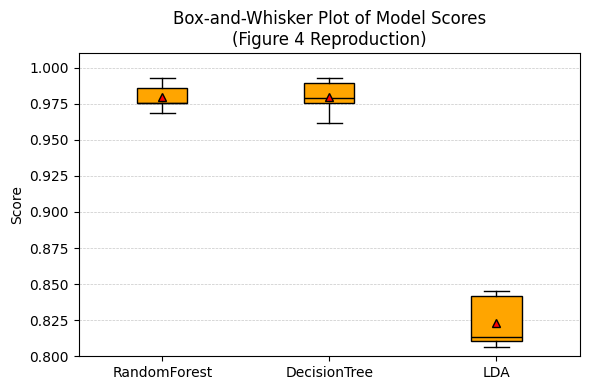

In [10]:
plt.figure(figsize=(6, 4))

# Prepare data in the order RandomForest, DecisionTree, LDA
data = [
    cv_results["RandomForest"],
    cv_results["DecisionTree"],
    cv_results["LDA"]
]

# Create boxplot
bp = plt.boxplot(
    data,
    labels=["RandomForest", "DecisionTree", "LDA"],
    patch_artist=True,      # to allow facecolor
    showmeans=True,         # show the mean marker
    meanprops=dict(
        marker='^',         # match paper’s little red triangle
        markerfacecolor='red',
        markeredgecolor='black'
    ),
    medianprops=dict(color='black'),
    whiskerprops=dict(color='black'),
    capprops=dict(color='black'),
    boxprops=dict(facecolor='orange', color='black')
)

plt.ylim(0.8, 1.01)
plt.ylabel("Score")
plt.title("Box-and-Whisker Plot of Model Scores\n(Figure 4 Reproduction)")
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

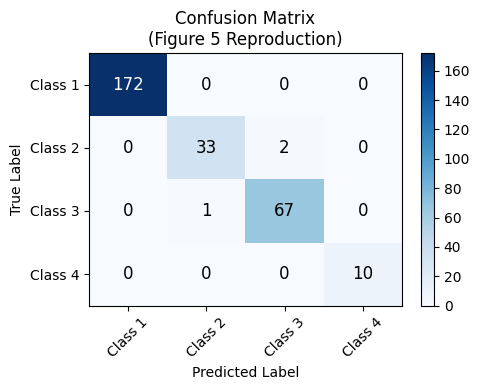

In [11]:

plt.figure(figsize=(5, 4))
cmap = plt.cm.Blues

# Display the heatmap
plt.imshow(cm, interpolation="nearest", cmap=cmap, aspect='auto')
plt.title("Confusion Matrix\n(Figure 5 Reproduction)")
plt.colorbar()

# Tick labels
class_labels = ["Class 1", "Class 2", "Class 3", "Class 4"]
plt.xticks(np.arange(4), class_labels, rotation=45)
plt.yticks(np.arange(4), class_labels)

# Annotate each cell with the count
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, f"{cm[i, j]}",
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black",
            fontsize=12
        )

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


# Plotted Label | Underlying Code | Meaning
# Class 1       |               0 | No anemia
# Class 2       |               1 | Microcytic anemia (MCV < 80)
# Class 3       |               2 | Normocytic anemia (80 ≤ MCV ≤ 100)
# Class 4       |               3 | Macrocytic anemia (MCV > 100)


# Rows = True class

# Columns = Predicted class

# The cell at row i, column j shows how many samples of true class i were predicted as class j.

# E.g. the top-left cell “162” means 162 no-anemia cases (Class 1) were correctly predicted as no-anemia.

# Because all off-diagonal cells are zero, every sample was classified into its correct category.

In [12]:
##Comparing Dnn with RFC
#Prepare labels for DNN
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

#Build a simple DNN
dnn = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])
dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#  Train DNN
dnn.fit(X_train, y_train_cat, epochs=30, batch_size=16, validation_split=0.1, verbose=1)



/opt/anaconda3/envs/college/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-28 21:15:25.018396: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-04-28 21:15:25.018431: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-04-28 21:15:25.018443: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-04-28 21:15:25.018469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-28 21:15:25.018485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Create

Epoch 1/30


2025-04-28 21:15:25.276224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5410 - loss: 3.2490 - val_accuracy: 0.5263 - val_loss: 1.2845
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6256 - loss: 1.1224 - val_accuracy: 0.5526 - val_loss: 1.1355
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6619 - loss: 0.9448 - val_accuracy: 0.5789 - val_loss: 0.9965
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6612 - loss: 0.9078 - val_accuracy: 0.6053 - val_loss: 1.0931
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7284 - loss: 0.7976 - val_accuracy: 0.6579 - val_loss: 0.8206
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7320 - loss: 0.7650 - val_accuracy: 0.6754 - val_loss: 0.7586
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7369 - loss: 0.7237 - val_accuracy: 0.6228 - val_loss: 0.7749
Epoch 8/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7243 - loss: 0.7354 - val_accuracy: 0.7105 - val_loss: 0.7166
Ep

In [14]:
#Evaluate DNN
dnn_loss, dnn_acc = dnn.evaluate(X_test, y_test_cat, verbose=1)
print("DNN Accuracy:", dnn_acc)
y_pred_dnn = dnn.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred_dnn, target_names=["No","Micro","Normo","Macro"]))



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7382 - loss: 0.5863
DNN Accuracy: 0.7473683953285217
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

          No       0.87      0.97      0.91       172
       Micro       0.41      0.54      0.47        35
       Normo       0.58      0.41      0.48        68
       Macro       0.00      0.00      0.00        10

    accuracy                           0.75       285
   macro avg       0.47      0.48      0.47       285
weighted avg       0.71      0.75      0.72       285



/opt/anaconda3/envs/college/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/college/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/college/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [15]:
# Compare confusion matrices
print("RF Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("DNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dnn))

RF Confusion Matrix:
 [[172   0   0   0]
 [  0  33   2   0]
 [  0   1  67   0]
 [  0   0   0  10]]
DNN Confusion Matrix:
 [[166   1   5   0]
 [  5  19  11   0]
 [ 19  21  28   0]
 [  1   5   4   0]]
